# **Fitting and Error Analysis**
### *Non-Interview Option* 

## <ins>Outline</ins>
An Example and an Exercise for Fitting and Error Analysis: 

Example: Turning in Homework   

    Explanation: Over the course of the PSI master's program, there are approximately 30 homework assignments. On the first few homework assignements, students are quite prompt with handing them in by the due date. As time goes on, however, and the reality sets in that these students are not penalized for late homeworks, more and more of them decide to hand in homeworks late. In this example, we will be analizing a (made up) data set which shows the homework assignment (in the order of earliest to latest due date) versus the number of students who have turned in said homework assignment on time. There are a total of 27 PSI students, and one can see that all students handed the first homework in on time, but by the last homework assignment, only two students handed in the homework by the deadline. We will be fitting a curve to this trend and analyzing how good our fit is.   

Data Analysis:   
1. Fit a function to the data   
   A. Eyeball Fit   
   B. Optimize Fit (Poisson Distribution because we don't have error bars)  
2. Jack-Knife Analysis   
   A. Plot optimized lines while leaving out a different data point each time   
   B. Contour Plots in parameter space   
   C. Plot bounds on error
3. Outlier Rejection


Exercise: Goose Poo on Perimeter's Lawn

    Explanation: The geese that live around Perimeter leave some lovely "presents" on the lawn. For some reason, potentially having to do with migration patterns or snow cover, there is more visible excrement in the summer months than in the winter months. We can fit a curve to these data, and also attempt to use some outlier rejection methods to get a cleaner fit.
     
   
---

Before doing anything, let's add the packages we'll need:
- CSV: used for reading "Comma Separated Value" files. We will use this to read our data
- CairoMakie: used for making beautiful plots 
- Optim: for optimizing functions
- DataFrames: for reading the csv
- Statistics: for finding the mean and standard deviation of the data

In [1]:
] add CSV

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
] add CairoMakie

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [3]:
] add Optim

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [4]:
] add DataFrames

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [5]:
] add Statistics

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [6]:
using CSV
using CairoMakie
using Optim
using DataFrames
using Statistics

---
## Example: Homework

Let's download the data:

In [7]:
hwdata = CSV.read("/home/bfriedmanshaw/Numerical Methods/Fitting&Error/Non-Interview/hw_turn_in_data.csv", DataFrame);
# Note, change this to the path of the data in your own directory

In [8]:
hwdata.hwNum; # This allows us to see the first column which is named hwNum and numbers
             # the homework assignments 1 through 30

In [9]:
hwdata.ontime;# This shows how many students turned in their homework assignments on time for each homework
              # one through 30.

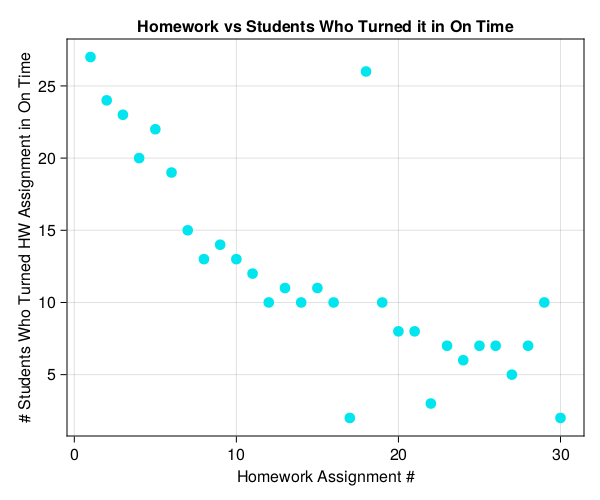

In [10]:
# Let's plot the data to see what it looks like:

f = Figure(resolution=(600,500))
Axis(f[1, 1];
    xlabel="Homework Assignment #",
    ylabel="# Students Who Turned HW Assignment in On Time",
    title="Homework vs Students Who Turned it in On Time")
scatter!(hwdata.hwNum, hwdata.ontime, markersize=15, color=:turquoise2)
f

---
### 1. A. Eyeball Fit

In [11]:
# Let's assume it's a power law fit y = ax^k

a_guess = 40 
k_guess = -0.5; 

# I guessed these values by playing around with some curves on desmos to see what might fit

In [12]:
xx = LinRange(0, 30, 20); # LinRange(min,max,num) makes an array of 'num' values from 'min' to 'max'
                         # and is therefore wonderful to make a sort of x axis that can give values to
                         # a function for plotting purposes

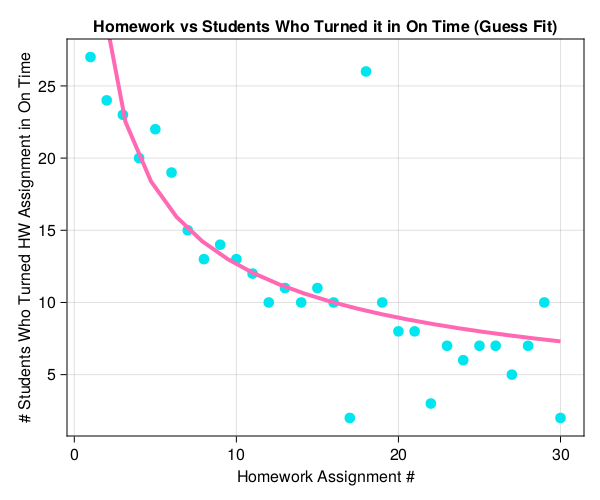

In [13]:
f = Figure(resolution=(600,500))
Axis(f[1, 1]; 
    xlabel="Homework Assignment #",
    ylabel="# Students Who Turned HW Assignment in On Time",
    title="Homework vs Students Who Turned it in On Time (Guess Fit)")
scatter!(hwdata.hwNum, hwdata.ontime, markersize=15, color=:turquoise2)

yy_guess = a_guess.*xx.^k_guess # Plotting our guess at a best fit line
lines!(xx, yy_guess, color=:hotpink, linewidth=4)

f

### 1. B. Optimized Fit (Poisson Distribution)

We should first talk a little bit about how the optimization works.

Optimization function: landscape over which we would like to find a maximum. In our example, we would like to find the parameters (b,m,q) that minimize the best fit line's distance from each point in the data set. 

Our Optimization function for this example: Poisson Distribution (because it doesn't need errors and we know our data is discrete and exact -- has no error/sigma value)

$$P(X=k)= \frac{\lambda^k e^{-\lambda}}{k!}$$

Here, k will be the number of students turning in a homework assignment on time and $\lambda$ will be the average number of students turning in each homework assignment.

More specifically, the optimization function will be the product of the Poisson probabilities for each data point. SO! This means we're centering each poisson distribution around the predicted value for that data point, and that predicted value is our $\lambda$. This is what each poisson distribution will look like (y is number of homeworks turned in on time):

$$P(y) = \frac{{y_{pred}}^{y} e^{-y_{pred}}}{y!}$$


To get rid of possible floating point error (if the probability happens to be small), we can take the log of this value because maximizing the log of a function is (positive functions specifically) is the same as maximizing the function itself. 

Nelder-Mead algorithm to find a maximum of the function: creates a triangle (or higher dimensional polygon) at some given initial point on the Loss/Optimization Function, checks the "heights"/values of the function at each corner of the triangle, creates a new, usually smaller, triangle around/near the highest point or side of the triangle (there are some variations of the algorithm), and repeats until it has (literally) triangulated its way to a maximum.


Sketch of what's happening:
1. Parameters of the best fit line are inputs to our optimization function (sum of the logs of Poisson distribution)
2. Nelder-Mead algorithm maximizes this function - the maximum corresponds to essentially centering the peak of each poisson distribution close to the actual data point which would give a probabalistically more accurate line of best fit
3. Algorithm spits out the parameters that are at the maximum and we can use those parameters to plot this optimized best fit line.

In [14]:
function poisson_log_likelihood(y, y_pred)
    return -sum(log.((y_pred.^y).*exp.(-y_pred)./factorial.(big.(y))))
end

poisson_log_likelihood (generic function with 1 method)

In [15]:
function model(x, a, k)
    y_pred = a.*x.^k
    return y_pred
end

model (generic function with 1 method)

In [16]:
function objective(x, y, a, k)
    y_pred = model(x, a, k)
    return poisson_log_likelihood(y, y_pred)
end

objective (generic function with 1 method)

In [17]:
objective(hwdata.hwNum,hwdata.ontime,a_guess +0.,k_guess+0.)

87.06712309775485064340423098250252321520162776469718825631453945347026672870379

In [18]:
# Now let's optimize this objective function: note that we start our neldermead method at the eyeballed values for
# b,m,q. And we also add a 0. to tell julia they're all floats (decimals) instead of integers
result = optimize(p -> objective(hwdata.hwNum, hwdata.ontime, p[1], p[2]),
                  [a_guess,k_guess] .+ 0.);

In [19]:
a_opt,k_opt = Optim.minimizer(result) # this is the command that reads out the optimize results

2-element Vector{Float64}:
 34.542339381232196
 -0.4568063786772919

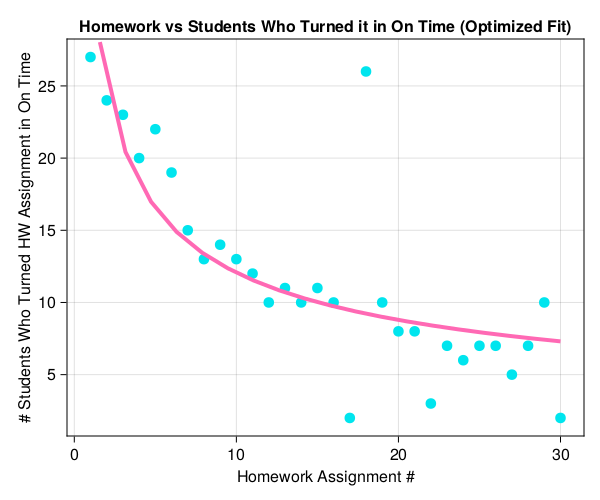

In [20]:
# Now to plot our optimized best-fit line:
f = Figure(resolution=(600,500))
Axis(f[1, 1]; 
    xlabel="Homework Assignment #",
    ylabel="# Students Who Turned HW Assignment in On Time",
    title="Homework vs Students Who Turned it in On Time (Optimized Fit)")

scatter!(hwdata.hwNum, hwdata.ontime, markersize=15, color=:turquoise2)

yy_opt = a_opt.*xx.^k_opt # Plotting our guess at a best fit line
lines!(xx, yy_opt, color=:hotpink, linewidth=4)

f

---
### 2. A. Jack Knife

Jack knife analysis is when we fit the data repeatedly, except each iteration has one point removed. This way we can determine if any points are significantly throwing off the fit.

In [21]:
n = length(hwdata.hwNum)

A_jack = zeros(n)
K_jack = zeros(n)

for i in 1:n
    x_sub = append!(hwdata.hwNum[1:(i-1)], hwdata.hwNum[(i+1):n]) #ith point removed from x data
    y_sub = append!(hwdata.ontime[1:(i-1)], hwdata.ontime[(i+1):n])#ith point removed from y data
    result = optimize(p -> objective(x_sub, y_sub, p[1], p[2]),
                  [a_guess,k_guess] .+ 0.)
    a,k = Optim.minimizer(result)
    A_jack[i] = a
    K_jack[i] = k
end

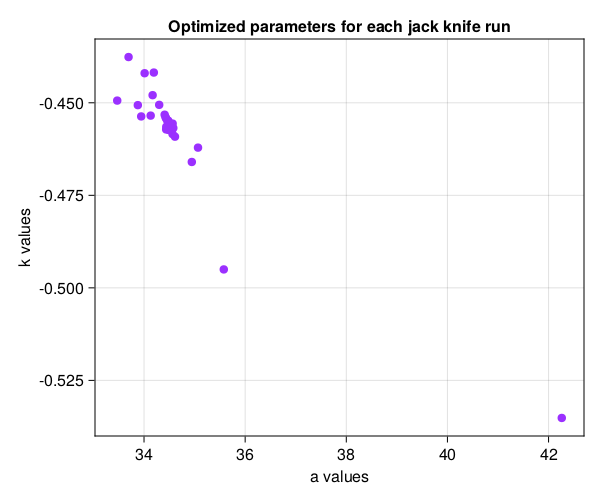

In [22]:
# Plotting the a and k values
f = Figure(resolution=(600,500))
Axis(f[1, 1];
    xlabel="a values",
    ylabel="k values",
    title="Optimized parameters for each jack knife run")
scatter!(A_jack, K_jack, color=:purple1)
f

---
### 2. B. Contour Plot in Parameter Space

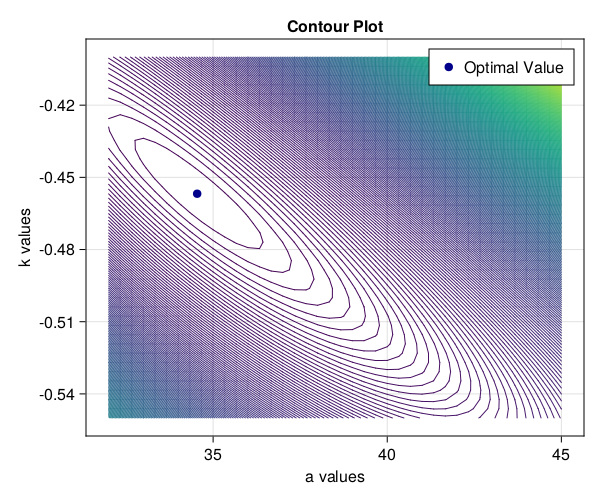

In [23]:
# Range of a,k values to plot
avals = LinRange(32., 45., 40)
kvals = LinRange(-0.55, -0.4, 40);
# Compute the objective function for each point in a grid
og = [objective(hwdata.hwNum, hwdata.ontime,a,k)
      for a in avals, k in kvals]
f = Figure(resolution=(600,500))
ax = Axis(f[1, 1];
    xlabel="a values",
    ylabel="k values",
    title="Contour Plot")
contour!(avals, kvals, og, levels=300) # contour plot
scatter!(a_opt,k_opt,color=:darkblue,label="Optimal Value")
axislegend(ax)
f

---
### 2.C. Error Bounds
We can use the averages we obtained from the Jack Knife analysis to determine error bounds on our model

In [24]:
# Finding averages from jack knife data
a_jack = mean(A_jack)
k_jack = mean(K_jack)
a_jack, k_jack

(34.67304633078218, -0.45802815026280236)

In [25]:
# Finding standard deviation
sigma_a_jack = (n-1)/n * std(A_jack .- a_jack)
sigma_k_jack = (n-1)/n * std(K_jack .- k_jack)

0.016797798347446727

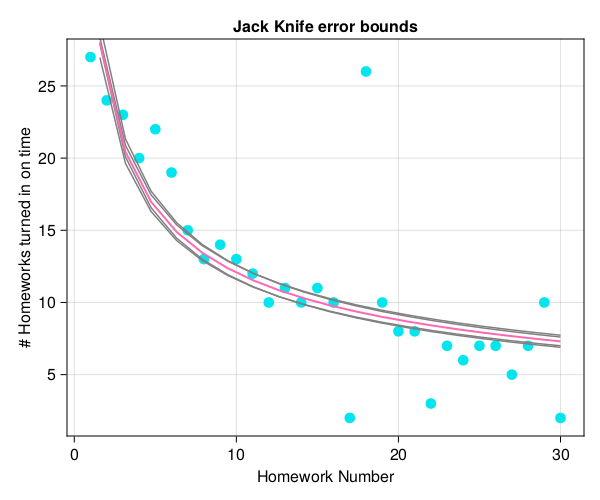

In [26]:
# Plotting error bounds
f = Figure(resolution=(600,500))
Axis(f[1, 1];
    xlabel="Homework Number",
    ylabel="# Homeworks turned in on time",
    title="Jack Knife error bounds")
scatter!(hwdata.hwNum, hwdata.ontime, markersize = 15, color = :turquoise2)

lines!(xx, (a_jack .+ sigma_a_jack) .* xx .^ k_jack, color=:grey)
lines!(xx, (a_jack .- sigma_a_jack) .* xx .^ k_jack, color=:grey)
lines!(xx, a_jack .* xx .^ (k_jack .+ sigma_k_jack), color=:grey)
lines!(xx, a_jack .* xx .^ (k_jack .- sigma_k_jack), color=:grey)

lines!(xx, a_opt .* xx .^ k_opt, color=:hotpink, linewidth=2)
f

---
### 3. Outlier Rejection
$$P(y) = \frac{{y_{pred}}^{y} e^{-y_{pred}}}{y!}$$

So originally we have our probability distribution function centered at each $y_{pred}$. As mentioned before, we use this probabilty distribution funciton, take the product of all of the probability distribution functions corresponding to each data point, and use this final product (well really log of that final product so the values aren't too big or too small to give unmanageable floating point errors) as a function that we optimize over. We optimize to make each of the pdfs as close as possible to being centered around our true data points.

Now how do we do outlier rejection on this? See the figure below -- if a data point is close to say y data value = 20, the poisson distribution centered at something like 7, 8, or 9 would be very suboptimal. The algorithm would search the parameter space for values that could shift the poisson (derived with y_pred from the model) over closer to the data point. The reason the model shifts so much is that we're really taking a log of the poisson distributions - see figure below - and outliers turn out to be very negative values in the log poisson function. This has a huge impact on the optimization, and the model shifts away to avoid the big negative values.

But if the point is an outlier and we would really rather it not shift our model like this, we need to figure out how to make our algorithm okay with it. One way we can do this is to change the look of our distribution so the log plot doesn't go very negative on the ends. We can just add a little rectangle bit to the bottom - see figure 3.


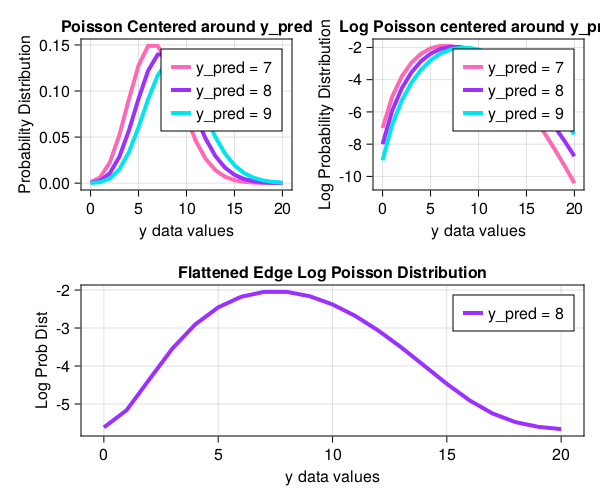

In [41]:
# Picture of what's happening:

y_pred1 = 7
y_pred2 = 8
y_pred3 = 9

y = LinRange(0,20,21)

poisson1 = (y_pred1.^y)exp.(-y_pred1)./factorial.(Int.(y))
poisson2 = (y_pred2.^y)exp.(-y_pred2)./factorial.(Int.(y))
poisson3 = (y_pred3.^y)exp.(-y_pred3)./factorial.(Int.(y))

logpois1 = log.((y_pred1.^y)exp.(-y_pred1)./factorial.(Int.(y)))
logpois2 = log.((y_pred2.^y)exp.(-y_pred2)./factorial.(Int.(y)))
logpois3 = log.((y_pred3.^y)exp.(-y_pred3)./factorial.(Int.(y)))

newlogpois2 = log.((0.1) * (1. / 30.) .+ (1. - 0.1) * ((y_pred2.^y).*exp.(-y_pred2)./factorial.(big.(y))))

f = Figure(resolution=(600,500))
ax1 = Axis(f[1, 1];
    ylabel="Probability Distribution",
    xlabel="y data values",
    title="Poisson Centered around y_pred")
lines!(y,poisson1,color =:hotpink, linewidth=4, label="y_pred = 7")
lines!(y,poisson2,color =:purple1, linewidth=4, label="y_pred = 8")
lines!(y,poisson3,color =:turquoise2, linewidth=4, label="y_pred = 9")
axislegend(ax1)

ax2 = Axis(f[1, 2];
    xlabel = "y data values",
    ylabel = "Log Probability Distribution",
    title = " Log Poisson centered around y_pred")
lines!(y,logpois1,color =:hotpink, linewidth=4, label="y_pred = 7")
lines!(y,logpois2,color =:purple1, linewidth=4, label="y_pred = 8")
lines!(y,logpois3,color =:turquoise2, linewidth=4, label="y_pred = 9")
axislegend(ax2)

ax3 = Axis(f[2,1:2];
    ylabel="Log Prob Dist",
    xlabel="y data values",
    title="Flattened Edge Log Poisson Distribution")
lines!(y,newlogpois2,color =:purple1, linewidth=4, label="y_pred = 8")
axislegend(ax3)

f

In [28]:
# Now to put this knowledge to use!
#outlier rejecting function
function objective_outliers(x, y, a, k)

    frac_bad = 0.1 # in our gaussian, we assume that 10% of area on the tails would only contain outlier datapoints
    like_bad = frac_bad * (1. / 30.) # 1/range of y-data

    y_pred = a .* x .^k
    like_good = (1. - frac_bad)
    like_good = (1. - frac_bad) * ((y_pred.^y).*exp.(-y_pred)./factorial.(big.(y)))
    #1 ./(sqrt(2*π) .* sigma) .* exp.(-0.5 * (y .- y_pred).^2 ./ sigma.^2)
    #^ normal distribution but with just 99% of original area
    
    like = like_bad .+ like_good
    # ^ re-shapes our distribution function so that the log of values on the tails don't become gigantic negative
    # numbers that influence the placement of the best-fit line
    loglike = log.(like)

    return -sum(loglike)
end

objective_outliers (generic function with 1 method)

In [29]:
result = optimize(p -> objective_outliers(hwdata.hwNum, hwdata.ontime, p[1], p[2]),
                  [a_guess,k_guess] .+ 0.)

 * Status: success

 * Candidate solution
    Final objective value:     7.965527e+01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    34
    f(x) calls:    70


In [30]:
a_outlier, k_outlier = Optim.minimizer(result)

2-element Vector{Float64}:
 35.69627013713432
 -0.49141978961035615

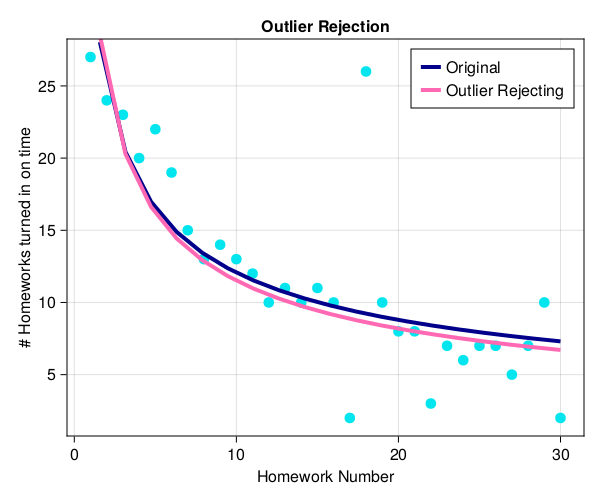

In [31]:
f = Figure(resolution=(600,500))
ax = Axis(f[1, 1];
    xlabel="Homework Number",
    ylabel="# Homeworks turned in on time",
    title="Outlier Rejection")
scatter!(hwdata.hwNum, hwdata.ontime, markersize = 15, color = :turquoise2)

lines!(xx, a_opt .* xx .^ k_opt, color=:darkblue, linewidth=4, label="Original")
lines!(xx, a_outlier .* xx .^ k_outlier, color=:hotpink, linewidth=4, label="Outlier Rejecting")
axislegend(ax)
f

---
## Exercise: Goose Poo

This exercise will have the same form as the above example. Some differences: here we will use a gaussian distribution and the data points have error bars, additionally our data looks more like a gaussian so we will make the model a gaussian fit.

Data Analysis:   
1. Fit a function to the data   
   A. Eyeball Fit (Already done for you)  
   B. Optimize Fit (Gaussian Distribution)  
2. Jack-Knife Analysis   
   A. Plot optimized lines while leaving out a different data point each time   
   B. Contour Plots in parameter space   
   C. Plot bounds on error
3. Outlier Rejection

In [32]:
goosedata = CSV.read("/home/bfriedmanshaw/Numerical Methods/Fitting&Error/Non-Interview/goose_data.csv", DataFrame);

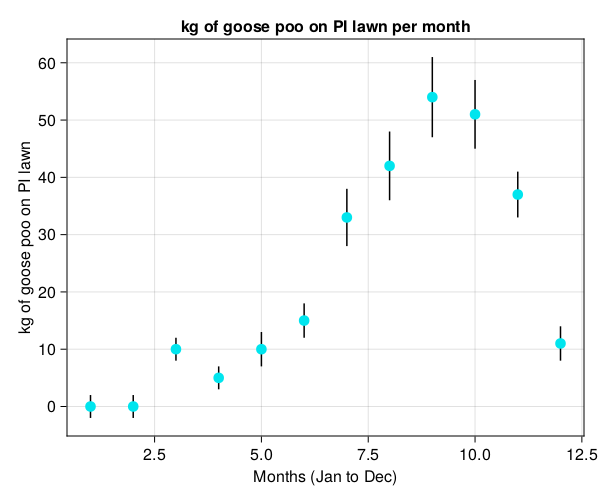

In [42]:
f = Figure(resolution=(600,500))
Axis(f[1, 1];
    xlabel="Months (Jan to Dec)",
    ylabel="kg of goose poo on PI lawn",
    title="kg of goose poo on PI lawn per month")
errorbars!(goosedata.month, goosedata.kgpoo, goosedata.sigmapoo)
scatter!(goosedata.month, goosedata.kgpoo, markersize=15, color=:turquoise2)

f

---
### 1. A. Eyeball Fit

In [34]:
A_guess = 57
B_guess = 9
C_guess = 4

4

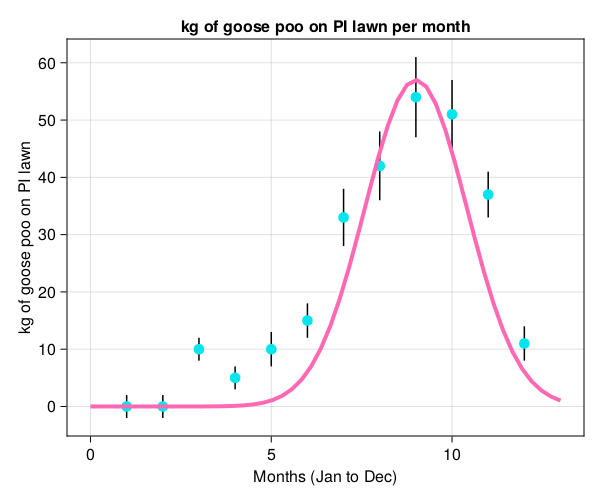

In [35]:
xx = LinRange(0, 13, 50)

f = Figure(resolution=(600,500))
Axis(f[1, 1];
    xlabel="Months (Jan to Dec)",
    ylabel="kg of goose poo on PI lawn",
    title="kg of goose poo on PI lawn per month")
errorbars!(goosedata.month, goosedata.kgpoo, goosedata.sigmapoo)
scatter!(goosedata.month, goosedata.kgpoo, markersize=15, color=:turquoise2)

yy_guess = A_guess.* exp.(.-(xx .- B_guess).^2 ./ C_guess) # Plotting our guess at a best fit line
lines!(xx, yy_guess, color=:hotpink, linewidth=4)

f

### 1. B. Optimized Fit (Gaussian Distribution)

In [36]:
function gaussian_log_likelihood(x, mean, sigma)
    return sum(-log.(sigma * sqrt(2*π)) - 0.5 * (x - mean).^2 ./ sigma.^2)
end

gaussian_log_likelihood (generic function with 1 method)

In [37]:
function model_gauss(x, A, B, C)
    y_pred = A .* exp.(-(x .- B).^2 ./ C)
    return y_pred
end

model_gauss (generic function with 1 method)

You got this! Try the rest yourself! By the rest, I mean specifically, finishing 1.B. through and including 3.

---
### 2.A. Jack-Knife Analysis

---
### 2.B. Contour Plots in Parameter Space
(With three parameters, try three plots where you have A vs. B, B vs. C, and A vs. C)

---
### 2.C. Bounds on Error

---
### 3. Outlier Rejection